# Neural network system model for towing Kite

In this Jupyter Notebook we train the neural network system model for the towing kite.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from nn_tools import get_keras_model, NNPredictModel

In [2]:
%matplotlib notebook

# Load data and pre-process data

- We load the previously created training data (100 sequences of MPC controlled towing kite)
- In post processing, we retrieve the following sequences from the ``do_mpc.data.Data`` object:
    - states
    - inputs
    - tether force
    - kite height
- We filter out sequences that did not converge (some inital conditions were poorly chosen) based on critera ``T_f > 1e6``.
- We filter out sequences with very large or very small values of ``w_ref`` and ``E_0``.

This is done in exactly the same way for the GP.

In [4]:
%%capture 

plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))



In [5]:
print(f'After filtering we still have {len(res)} / 100 sequences.')

After filtering we still have 38 / 100 sequences.


We plot some of the remaining sequences to visually inspect the training data:

<IPython.core.display.Javascript object>


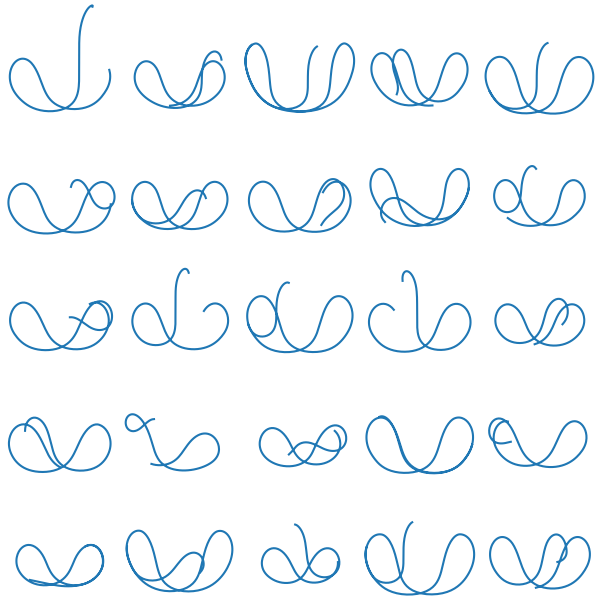

In [6]:
n_res = min(len(res),25)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(6,6))
for i, res_i in enumerate(res[:n_res]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0])
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
fig.tight_layout(pad=0)


## Create training, test and validation data

For testing purposes, we set aside a fixed number of sequences that are not using for training.

With the remaining sequences we prepare our input and output data for the neural network.
This data is then randomly partitioned into (10%) validation and (90%) training data.

In [7]:
nn_in = []
nn_out = []

n_test = 20
train_val_res = res[:-n_test]
test_res = res[-n_test:]


for i, res_i in enumerate(train_val_res):
    x_now = res_i['states'][:,:] 

    nn_in.append(np.concatenate((res_i['input'], res_i['wind'], x_now),axis=1)[:-1,:])

    x_next = np.roll(res_i['states'],-1,axis=0)[:,:]
    dx = x_next - x_now

    nn_out.append(np.concatenate((res_i['T_F'], res_i['height'], dx),axis=1)[:-1,:])

n_traj = len(res)
    

    
nn_in = np.concatenate(nn_in)
nn_out = np.concatenate(nn_out)

nn_in_train, nn_in_test, nn_out_train, nn_out_test = train_test_split(nn_in, nn_out, test_size=0.1, random_state=42)

Scale input and output data:

In [8]:
in_scaler = preprocessing.StandardScaler().fit(nn_in_train)
out_scaler = preprocessing.StandardScaler().fit(nn_out_train)

nn_in_train_scaled = in_scaler.transform(nn_in_train)
nn_out_train_scaled = out_scaler.transform(nn_out_train)

nn_in_test_scaled = in_scaler.transform(nn_in_test)
nn_out_test_scaled = out_scaler.transform(nn_out_test)


print(f'We have m = {nn_in_train_scaled.shape[0]} training samples')

We have m = 3223 training samples


Get the keras NN model for prediction ``model`` and the ``activation_model`` for the computation of the BLL covariance.

In [9]:
np.random.seed(99)
tf.random.set_seed(99)

architecture = [nn_in_train.shape[1], 20,20, nn_out_train.shape[1]]

nn_model, activation_model = get_keras_model(architecture, 'tanh')

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MSE,
)

2021-12-01 13:43:31.641934: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 13:43:31.642489: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the neural network. We capture the output to better display the results on Github.

In [10]:
%%capture
history = nn_model.fit(
    nn_in_train_scaled, 
    nn_out_train_scaled,
    validation_data = (nn_in_test_scaled, nn_out_test_scaled),
    epochs=1000,
    batch_size=200,
)

2021-12-01 13:44:07.382337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Plot the training progression (training loss and validation loss)

<IPython.core.display.Javascript object>


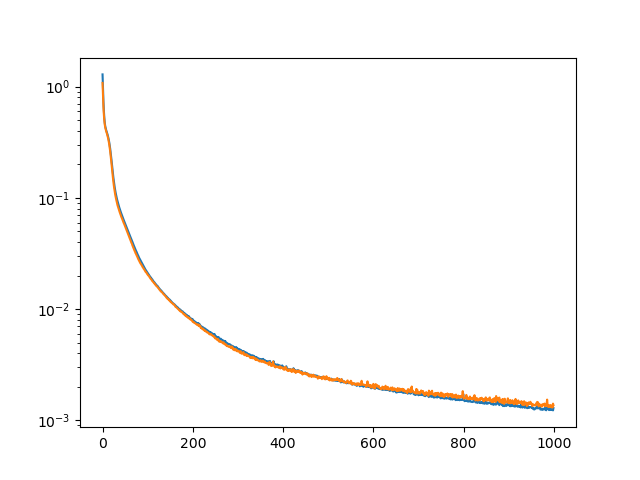

In [11]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'], label='training loss')
ax.semilogy(history.history['val_loss'], label='validation loss')

## Open-loop predictions

Compute an open-loop prediction for one of the test cases. Choose the case with ``case = ...``.
The open-loop predictions are computed through the class ``NNPredictModel``.

In [12]:
case = 0

x0 = (test_res[case]['states'][0]).reshape(-1,1)
a_train = activation_model.predict(nn_in_train_scaled)

pm = NNPredictModel(nn_model, activation_model, 
                    a_train, in_scaler, out_scaler, x0,
                   sig_e=1, sig_w=1e3)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


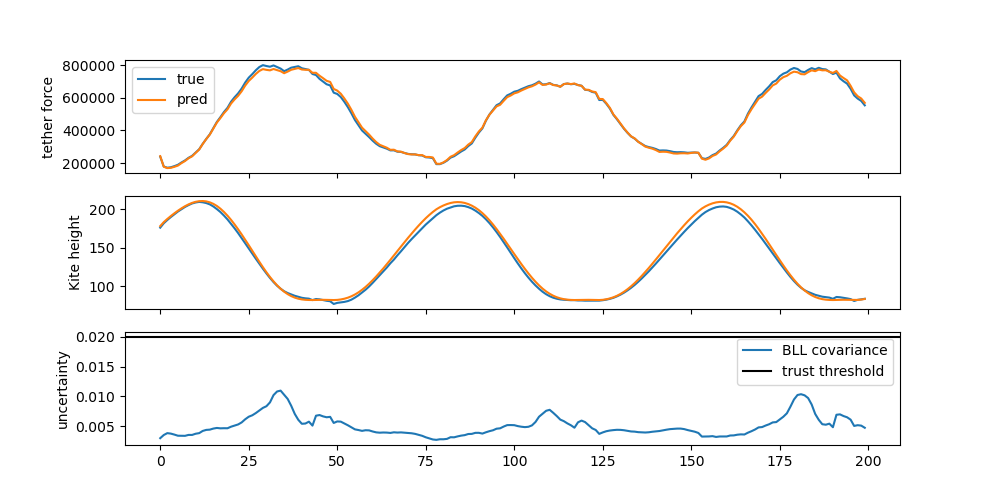

In [17]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,5))

ax[0].plot(pm.aux[:,0],label='true')
ax[0].plot(test_res[case]['T_F'], label='pred')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v, label='BLL covariance')
ax[2].set_ylabel('uncertainty')

trust_threshold = 0.02
ax[2].axhline(trust_threshold, label='trust threshold', color='k')
ax[2].legend()

Compute open-loop predictions for all test cases:

In [18]:
nn_traj = []
nn_trust = []
n_eval = min(20,len(test_res))

for i, res_i in enumerate(test_res[:n_eval]):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm.reset(x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm.make_step(u0,p)
    
    nn_traj.append(pm.x)
    nn_trust.append(pm.v)

Plot all test cases ($\phi$, $\theta$ diagram) and flag points with trust violations.

<IPython.core.display.Javascript object>


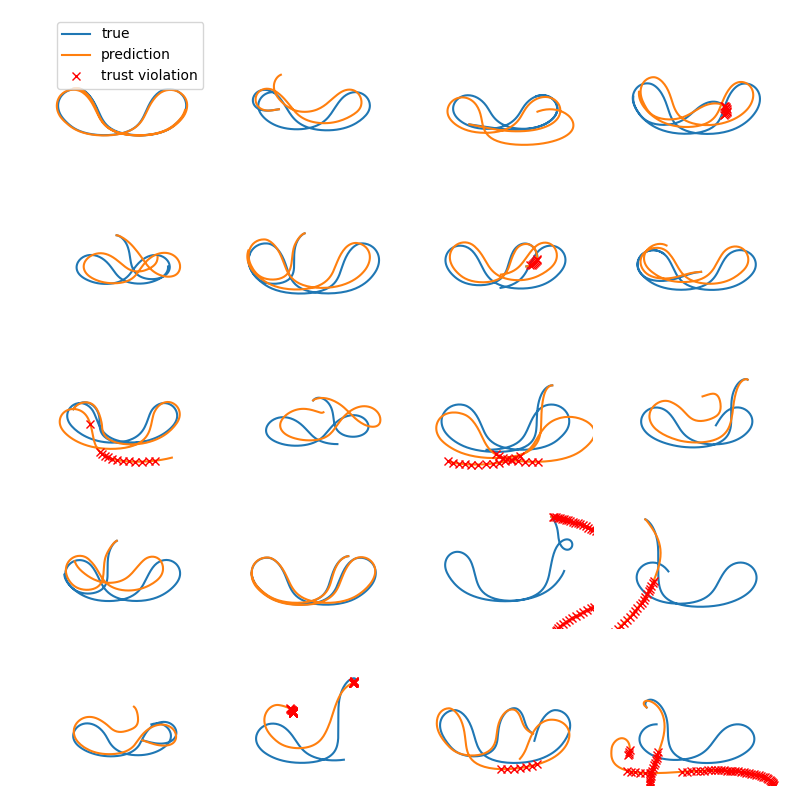

In [19]:
n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))

trust_threshold = 0.02


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0], label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj[i][:,1], nn_traj[i][:,0], label='prediction')
    
    viol_ind = (nn_trust[i]>= trust_threshold).flatten()
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj[i][1:,:][viol_ind,1], nn_traj[i][1:,:][viol_ind,0],
                                      'x', color='red', label='trust violation')
    
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

ax[0,0].legend()
ax[0,0].set_xlim(-np.pi/2,np.pi/2)
ax[0,0].set_ylim(0,np.pi/2)

fig.tight_layout()

## Export model

In [20]:
export_bool = False

if export_bool:
    export_name = 'S01_NN_M01'
    export_path = './nn_models/{}/'
    pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

    export_dict = {'a_train': a_train, 'in_scaler': in_scaler, 'out_scaler': out_scaler, 'C': pm.C}

    do_mpc.tools.save_pickle(export_path.format(export_name) + export_name + '_aux.pkl', export_dict)

    nn_model.save(export_path.format(export_name))

In [22]:
# Checksum
np.sum(nn_traj)

-171.2210149152047

Ensure that the trained model produces this result for the checksum:

S01_NN_M01: -171.2210149152047